# [TODO] Compare the analytical solution of trajectory for gaussian case

In [1]:
import numpy as np

In [2]:
delta_t = 0.05
t0 = 0.0
k0 = 0.1

def get_psi_dpsi_ddpsi(x,t):
    _psi = np.exp(1.0j * (k0 * x - 0.5*k0*k0*t))
    _dpsi = 1.0j * k0 * _psi
    _ddpsi = - k0 * k0 * _psi
    return (_psi, _dpsi, _ddpsi)

from tdse.analytic import Gaussian1D, gradient_Gaussian1D, laplacian_Gaussian1D
def get_psi_dpsi_ddpsi(x,t):
    _psi = Gaussian1D(x,t,k0)
    _dpsi = gradient_Gaussian1D(x,t,k0)
    _ddpsi = laplacian_Gaussian1D(x,t,k0)
    return (_psi, _dpsi, _ddpsi)

In [3]:
def prop_xx(xx_t, get_psi_dpsi_ddpsi, t, delta_t, log=False, g_zero_thres=1e-11, xx_diff_thres=1e-13):
    
    _t_next = t + delta_t
    
    _xx_t_k = xx_t

    while True:

        _psi, _dpsi, _ddpsi = get_psi_dpsi_ddpsi(_xx_t_k, _t_next)
        _g_k = xx_t - _xx_t_k + delta_t * (_dpsi / _psi).imag
        if log: print("xx_t_k: {:.16f} / g_k: {:.16f}".format(_xx_t_k, _g_k))

        if np.abs(_g_k) < g_zero_thres: break

        _psi_sq = (_psi.conj() * _psi).real
        _xx_t_k_next = _xx_t_k - ( (xx_t - _xx_t_k)*_psi_sq + delta_t * (_psi.conj()*_dpsi).imag ) / ( delta_t * (_psi.conj()*_ddpsi - _psi.conj() / _psi * (_dpsi*_dpsi)).imag - 1.0)
        assert np.abs(_xx_t_k_next - _xx_t_k) > xx_diff_thres
        _xx_t_k = _xx_t_k_next
    
    _xx_t_next = _xx_t_k
    
    return _xx_t_next

In [4]:
xx_t = 0.0
t = t0

for _t_idx in range(10):

    xx_t = prop_xx(xx_t, get_psi_dpsi_ddpsi, t, delta_t, log=True)
    t = t + delta_t
    
    print("t: {:.15f} / xx_t: {:.15f}".format(t,xx_t))

xx_t_k: 0.0000000000000000 / g_k: 0.0049813856005520
xx_t_k: 0.0039703119800188 / g_k: 0.0010308020770092
xx_t_k: 0.0047919308925743 / g_k: 0.0002132657839148
xx_t_k: 0.0049619184776155 / g_k: 0.0000441228661667
xx_t_k: 0.0049970874576131 / g_k: 0.0000091286406202
xx_t_k: 0.0050043636163986 / g_k: 0.0000018886370242
xx_t_k: 0.0050058689909059 / g_k: 0.0000003907427138
xx_t_k: 0.0050061804399100 / g_k: 0.0000000808412980
xx_t_k: 0.0050062448760232 / g_k: 0.0000000167253674
xx_t_k: 0.0050062582072994 / g_k: 0.0000000034603343
xx_t_k: 0.0050062609654255 / g_k: 0.0000000007159133
xx_t_k: 0.0050062615360580 / g_k: 0.0000000001481163
xx_t_k: 0.0050062616541169 / g_k: 0.0000000000306440
xx_t_k: 0.0050062616785423 / g_k: 0.0000000000063400
t: 0.050000000000000 / xx_t: 0.005006261678542
xx_t_k: 0.0050062616785423 / g_k: 0.0049759669183913
xx_t_k: 0.0089291697181055 / g_k: 0.0010913371092340
xx_t_k: 0.0097895879188255 / g_k: 0.0002393145389495
xx_t_k: 0.0099782656639124 / g_k: 0.0000524778388543

# index

In [5]:
import numpy as np

import matplotlib.pyplot as plt

In [6]:
x_arr = np.linspace(-1,1,51)
delta_x = x_arr[1] - x_arr[0]

x_p_arr = np.array([-0.999, -0.3, 0.02, 0.41, 0.995])

N_p, N_x, N_s = x_p_arr.size, x_arr.size, 5

In [7]:
i_p_arr = np.asarray((x_p_arr - x_arr[0]) // delta_x, dtype=int)
i_s0_p_arr_unshift = i_p_arr - int((N_s//2) - 1)
i_s0_p_arr = i_s0_p_arr_unshift - (i_s0_p_arr_unshift < 0) * i_s0_p_arr_unshift - (i_s0_p_arr_unshift + N_s - N_x > 0) * (i_s0_p_arr_unshift + N_s - N_x)

In [8]:
pow_mat = np.empty((N_p,N_s,N_s), dtype=float)
pow_mat[:,0,:] = 1.0

for _s_idx in range(N_s):
    _x_diff_p_arr = (x_arr[i_s0_p_arr+_s_idx] - x_p_arr)
    for _s_pow_idx in range(1,N_s):
        pow_mat[:,_s_pow_idx,_s_idx] = pow_mat[:,_s_pow_idx-1,_s_idx] * _x_diff_p_arr

In [9]:
k0 = 1.0
sf_arr = np.exp(1.0j * k0 * x_arr, dtype=complex)
dsf_arr = 1.0j * k0 * sf_arr
ddsf_arr = - k0 * k0 * sf_arr

ana_list = [sf_arr, dsf_arr, ddsf_arr]

In [10]:
sf_p_arr = np.zeros((N_p,), dtype=sf_arr.dtype)
dsf_p_arr = np.zeros((N_p,), dtype=sf_arr.dtype)
ddsf_p_arr = np.zeros((N_p,), dtype=sf_arr.dtype)

result_list = [sf_p_arr, dsf_p_arr, ddsf_p_arr]

In [11]:
from scipy.special import factorial
from numpy.linalg import solve

deriv_order_list = [0,1,2]

assert len(deriv_order_list) == len(result_list)

for _deriv_order, _f_arr in zip(deriv_order_list, result_list):
    b_mat = np.zeros((N_p,N_s), dtype=float)
    b_mat[:,_deriv_order] = factorial(_deriv_order, exact=True)

    coef_mat = solve(pow_mat, b_mat)
    
    for _s in range(N_s):
        _f_arr += sf_arr[i_s0_p_arr+_s] * coef_mat[:,_s]

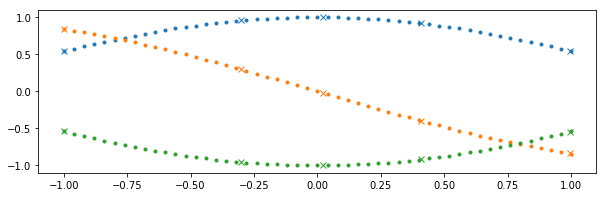

In [12]:
fig, ax = plt.subplots(figsize=(10,3))

for _f, _f_p in zip(ana_list, result_list):
    line, = ax.plot(x_arr, _f.real, '.')
    ax.plot(x_p_arr, _f_p.real, 'x', color=line.get_color())

# fig.savefig("fd-test-0.png")